**TLDR:** It doesn't always converge. Here are some examples of where it does converge. 

Original noise parameters ($\sigma_\Omega, \sigma_\Delta, \sigma_\epsilon$) based on "Experimental Bayesian Calibration of Trapped-Ion Entangling Operations" (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350).

Derivative noise parameters ($\sigma_I, \sigma_{f_{cl}}, \sigma_{f_{sb}}$) based on **single_qubit_rotations/single_qubit_noise_sim.ipynb**.

In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  8.073205 seconds (14.89 M allocations: 957.963 MiB, 7.63% gc time, 99.58% compilation time: <1% of which was recompilation)


In [2]:
using QuantumOptics
import PyPlot
using Random, Distributions
using ProgressBars
Random.seed!(0)

include("./molmer_sorensen.jl")
using .MolmerSorensen: construct_MS_chamber
const plt = PyPlot;

The Molmer-Sorensen Hamiltonian: $\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

## 0. Setup

Global variables

In [3]:
######################### Optimal parameter values #########################
# See molmer_sorensen_scans_zoomed.ipynb for how these were determined
INTENSITY_MS = 94326.65907221894 # W/cm^2
TRAP_FREQUENCY = 2.5e5 # Hz
WAVELENGTH_CL_MS = 7.291469940286511e-7 # m
B_STRENGTH = 0.0005999899999999999; # T

######################### Parameter noise values #########################
# See molmer_sorensen_noise_sim.ipynb for how these were determined

# Intensity 
Ω_opt = 1e7
κ = INTENSITY_MS/(Ω_opt^2)
σ_Ω = 0.2Ω_opt
σ_I = κ*sqrt(2*(σ_Ω^4) + 4*(σ_Ω^2)*Ω_opt^2 )

Normal_I = Normal(INTENSITY_MS, σ_I)

# Center-line frequency
δλ_MAX = 1e-15
C0 = 2.99792458e8
FREQUENCY_CL_MS = C0/WAVELENGTH_CL_MS
σ_f_cl = 2e3

Normal_f_cl = Normal(FREQUENCY_CL_MS, σ_f_cl)

# Trap frequency
σΔ = 2e3
σ_ν = σΔ
Normal_ν  = Normal(TRAP_FREQUENCY, σ_ν)

# Phase
PHASE = 0
σ_ϕ = 0.16*π
Normal_ϕ = Normal(PHASE, σ_ϕ)

######################### Other global variables #########################

CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])

N_SAMPLES = Int(1e4)
FINITE_RWA_CUTOFF = 1e20

TIMESCALE = 1e-6 # seconds 
DETUNING = 1e4 # Hz
GATE_TIME = 1/DETUNING # seconds
T_RANGE = 0:GATE_TIME*1e-3:GATE_TIME
AC_CORRECTION = 0; # Hz
PI_TIME = 2e-6

# Intialize chamber object, whose properties will be updated in the loop
MS_CHAMBER_TUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

VIB_MODE = IonSim.modes(MS_CHAMBER_TUNED)[1] # first vibrational mode
ket0_VIB_MODE = VIB_MODE[0]
dm0_VIB_MODE = dm(ket0_VIB_MODE)

# Computational states 
ket_00 = CALCIUM40["S"] ⊗ CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ⊗ CALCIUM40["D"]
ket_10 = CALCIUM40["D"] ⊗ CALCIUM40["S"]
ket_11 = CALCIUM40["D"] ⊗ CALCIUM40["D"]
ρ_00 = dm(ket_00)
ρ_01 = dm(ket_01)
ρ_10 = dm(ket_10)
ρ_11 = dm(ket_11)

# Bell states 
ket_00_m_i11 = (ket_00 - 1im*ket_11)/√2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/√2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/√2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/√2
ρ_00_m_i11 = dm(ket_00_m_i11)
ρ_00_p_i11 = dm(ket_00_p_i11)
ρ_01_m_i10 = dm(ket_01_m_i10)
ρ_01_p_i10 = dm(ket_01_p_i10);

Helper function for measuring $\hat{Z}$

In [4]:
function ZZ_probs(ψf) # random projective measurement onto the computational basis
    p_00 = real(tr(ρ_00 * ψf))
    p_11 = real(tr(ρ_11 * ψf))
    p_01 = real(tr(ρ_01 * ψf))
    p_10 = real(tr(ρ_10 * ψf))

    return p_00, p_11, p_01, p_10
end

ZZ_probs (generic function with 1 method)

Helper function for plotting

In [60]:
function plot_populations_double(chamber, tout, sol; title = Nothing)

    # compute expectation values
    prob_00 = expect(ρ_00 ⊗ dm0_VIB_MODE , sol)  # 𝔼(|S⟩|S⟩)
    prob_11 = expect(ρ_11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|D⟩|D⟩)
    prob_01 = expect(ρ_01 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩)
    prob_10 = expect(ρ_10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|D⟩|S⟩)
    prob_00_p_i11 = expect(ρ_00_p_i11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|S⟩ + i|D⟩|D⟩)
    prob_00_m_i11 = expect(ρ_00_m_i11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|S⟩ - i|D⟩|D⟩)
    prob_01_p_i10 = expect(ρ_01_p_i10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩ + i|D⟩|S⟩)
    prob_01_m_i10 = expect(ρ_01_m_i10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩ - i|D⟩|S⟩)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (μs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis states")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (μs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell states")
    if title != Nothing
        fig.suptitle(title)
    end

    return fig
end

plot_populations_double (generic function with 1 method)

Test fidelity with optimal parameters

In [6]:
phase!(MS_CHAMBER_TUNED.lasers[1], 0)
phase!(MS_CHAMBER_TUNED.lasers[2], 0)

h = hamiltonian(MS_CHAMBER_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);

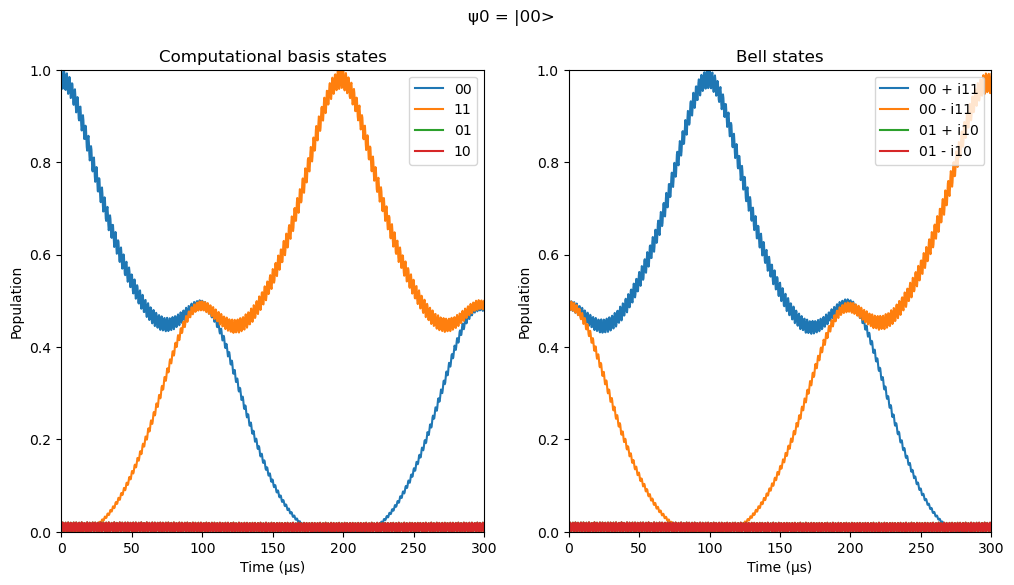

  3.767487 seconds (17.44 M allocations: 1011.737 MiB, 14.49% gc time, 92.20% compilation time)
Fidelity = 0.9952180313622945 + 6.065291655765218e-10im

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [7]:
@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h);
plot_populations_double(MS_CHAMBER_TUNED, tout00, sol00, title="ψ0 = |00>")

ρ_final = ptrace(dm(sol00[end]), 3)
print("Fidelity = ", fidelity(ρ_final, ρ_00_m_i11))

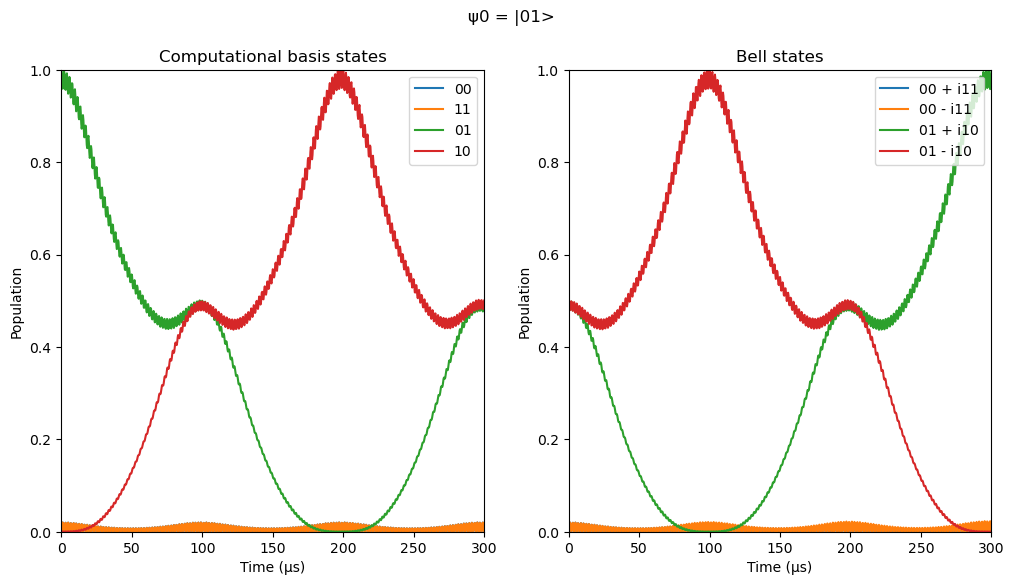

  0.355821 seconds (5.04 M allocations: 191.390 MiB, 25.48% gc time)
Fidelity = 0.9983217751910406 - 9.184549852027025e-9im

In [8]:
@time tout01, sol01 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_01 ⊗ ket0_VIB_MODE , h);
plot_populations_double(MS_CHAMBER_TUNED, tout01, sol01, title="ψ0 = |01>")

ρ_final = ptrace(dm(sol01[end]), 3)
print("Fidelity = ", fidelity(ρ_final, ρ_01_p_i10))

Functions to update true parameters, given measured parameters

### 1. Intensity
$\kappa = \frac{I}{\Omega^2} \Longrightarrow \Omega^2 = \frac{I}{\kappa} \Longrightarrow \Omega = \sqrt{\frac{I}{\kappa}}$

$\frac{\Omega_{\text{opt}}}{\overline{\Omega}} = \frac{\sqrt{I_{\text{opt}}/\kappa}}{\sqrt{\overline{I}/\kappa}} = \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}$

In the text, they update: $t_g \to t_g \frac{\Omega_{\text{opt}}}{\overline{\Omega}}$

Since $t_g \sim I$, here we will update: $\boxed{I \to I \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}}$

### 2. Center-line frequency

In the text, they update: $f_{\text{cl}} \to f_{\text{cl}} - (  \overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}} )$. 

**Mind the confusing notation**: here, $\omega_{\text{cl}}$ is not an angular frequency, they just use $\omega$ to denote the center-line *detuning* as opposed to the center-line frequency. With this in mind, it's clear that $\overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}}$ is exactly equivalent to $ \overline{f}_{\text{cl}} - f_{\text{cl, opt}}$. 

So we will update: $\boxed{f_{\text{cl}} \to f_{\text{cl}} - ( \overline{f}_{\text{cl}} - f_{\text{cl, opt}} )}$

### 3. Trap-frequency

In the text, they update: $f_{\text{sb}} \to f_{\text{sb}} - ( \overline{\delta} - \delta_{\text{opt}})$

So, once again, we simply update: $\boxed{\nu \to \nu - (\overline{\nu} - \nu_{\text{opt}})}$

In [9]:
# Intensity
function compute_I_new(chamber, I_bar)
    I = chamber.lasers[1].I(0)
    return I*sqrt(INTENSITY_MS/I_bar)
end

function update_intensity(chamber, I_new)
    intensity!(chamber.lasers[1], I_new)
    intensity!(chamber.lasers[2], I_new)
end

# Center-line frequency 
function compute_f_cl_new(chamber, f_cl_bar)
    λ_cl = chamber.lasers[1].λ
    f_cl = C0/λ_cl
    return f_cl - (f_cl_bar - FREQUENCY_CL_MS)
end

function update_f_cl(chamber, f_cl_new)
    wavelength!(chamber.lasers[1], C0/f_cl_new)
    wavelength!(chamber.lasers[2], C0/f_cl_new)
end

# Trap-frequency
function compute_ν_new(chamber, ν_bar)
    ν = chamber.iontrap.comfrequencies.z
    return ν - (ν_bar - TRAP_FREQUENCY)
end

function update_ν(chamber, ν_new)
    # Can't update the trap-frequency in-place
    # Must create a brand new chamber, with all the same properties except for the trap frequency
    I = chamber.lasers[1].I(0)
    λ_cl = chamber.lasers[1].λ
    chamber_new = construct_MS_chamber(
        ν_new,
        I,
        λ_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )

    # Recall: The detuning is based on the *target* trap-frequency
    chamber.lasers[1].Δ = TRAP_FREQUENCY + DETUNING - AC_CORRECTION
    chamber.lasers[2].Δ = -(TRAP_FREQUENCY + DETUNING - AC_CORRECTION)
    return chamber_new
end 

# Phase
function compute_ϕ_new(chamber, ϕ_bar)
    ϕ = chamber.lasers[2].ϕ(0)
    return ϕ - (ϕ_bar - PHASE)
end

function update_ϕ(chamber, ϕ_new)
    phase!(chamber.lasers[2], ϕ_new)
end
 

update_ν (generic function with 1 method)

Run the noise-sim to check our parameter-update functions

In [16]:
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
N_SAMPLES_TEST = Int(1e3)

fidelities = zeros(N_SAMPLES_TEST)
entanglement_entropies = zeros(N_SAMPLES_TEST)
for i in 1:N_SAMPLES_TEST
    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    I_new = rand(Normal_I)[1]
    if I_new<0
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
        continue
    end

    f_cl_new = rand(Normal_f_cl)[1]
    λ_cl_new = C0/f_cl_new
    δλ = abs(WAVELENGTH_CL_MS - λ_cl_new)
    if δλ > δλ_MAX
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
        continue
    end

    ν_new = rand(Normal_ν)[1]
    
    try
        # actual trap-frequency is ν
        update_intensity(MS_CHAMBER_UNTUNED, I_new)
        update_f_cl(MS_CHAMBER_UNTUNED, f_cl_new)
        MS_CHAMBER_UNTUNED = update_ν(MS_CHAMBER_UNTUNED, ν_new)

        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
        ρ_final = dm(sol[end])
        ρ_final_electronic = ptrace(ρ_final, 3)
        fid_i = fidelity(ρ_final_electronic, ρ_00_p_i11)
        S_i = entropy_vn(ρ_final_electronic)

        #@assert imag(fid) < 1e-8
        fidelities[i] = real(fid_i)
        entanglement_entropies[i] = S_i
    catch
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
    end
end

fidelities = fidelities[.~isnan.(fidelities)]
print("\nlength(fidelities) = ", length(fidelities))

entanglement_entropies = entanglement_entropies[.~isnan.(entanglement_entropies)]
print("\nlength(entanglement_entropies) = ", length(entanglement_entropies))

MS_CHAMBER_UNTUNED = Nothing;


100
200
300
400
500
600
700
800
900
1000
length(fidelities) = 995
length(entanglement_entropies) = 995

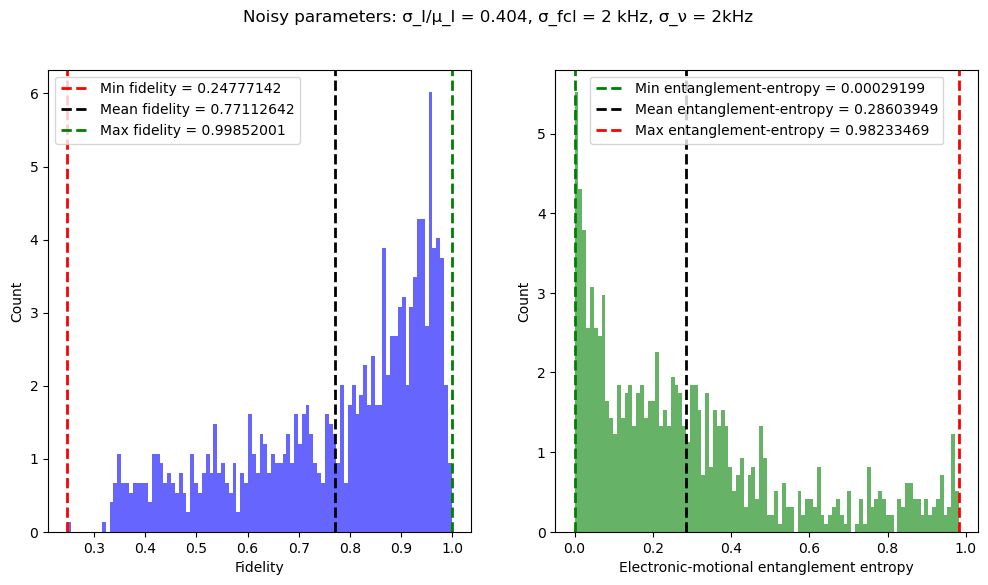

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.hist(fidelities, bins=100, density=true, alpha=0.6, color="b")
ax1.axvline(minimum(fidelities), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities); digits=8))")
ax1.axvline(mean(fidelities), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities); digits=8))")
ax1.axvline(maximum(fidelities), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities); digits=8))")
ax1.set_xlabel("Fidelity")
ax1.set_ylabel("Count")
ax1.legend()

ax2.hist(entanglement_entropies, bins=100, density=true, alpha=0.6, color="g")
ax2.axvline(minimum(entanglement_entropies), color="g", linestyle="--", linewidth=2, label="Min entanglement-entropy = $(round(minimum(entanglement_entropies); digits=8))")
ax2.axvline(mean(entanglement_entropies), color="k", linestyle="--", linewidth=2, label="Mean entanglement-entropy = $(round(mean(entanglement_entropies); digits=8))")
ax2.axvline(maximum(entanglement_entropies), color="r", linestyle="--", linewidth=2, label="Max entanglement-entropy = $(round(maximum(entanglement_entropies); digits=8))")
ax2.set_xlabel("Electronic-motional entanglement entropy")
ax2.set_ylabel("Count")
ax2.legend()

fig.suptitle("Noisy parameters: σ_I/μ_I = 0.404, σ_fcl = 2 kHz, σ_ν = 2kHz")
plt.display(fig)

# 1. 1D Bayesian parameter calibration: Intensity

$ P(\Theta|m) \propto P(m|\Theta) P(\Theta)$, up to some normalization


"The Bayesian inference requires an initial prior (i.e. $P(\Theta)$), and we must choose an initial set of particles to represent this prior. We choose a known continuous probability density function as prior."

For us: $\Theta = (f_{\text{cl}}) \Longrightarrow P(\Theta) \sim \mathcal{N}(\mu_{f_{\text{cl}}}, \sigma_{f_{\text{cl}}}) $

$\Longrightarrow \boxed{P(\Theta) = \frac{1}{\sqrt{2\pi \sigma_{f_{\text{cl}}}}} \exp\left[-\frac{1}{2}  \frac{(i - \mu_{f_{\text{cl}}})^2}{\sigma_{f_{\text{cl}}}^2} \right]}  $

"We can then initialize the particle filter from that probability function by randomly sampling $N_p$ times from the distribution and setting all the weights to $1/N_p$."

## 1.a. Compute the initial prior

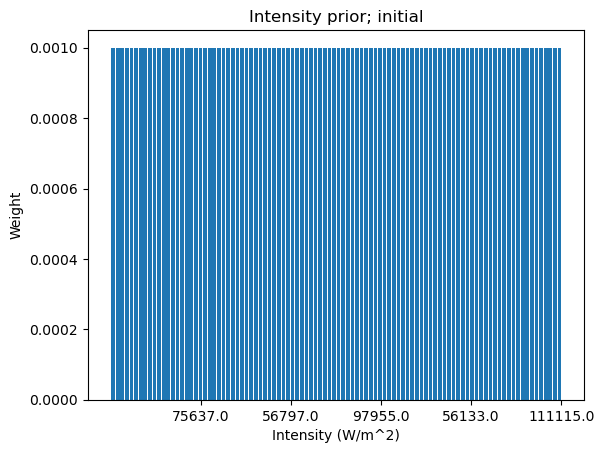

In [110]:
N_p_I_1d = Int(1e3)
particles_I_1d = []
weights_I_1d = []

n_collected_I_1d = 0
while n_collected_I_1d < N_p_I_1d
    I_new = rand(Normal_I)[1]
    if I_new<0
        continue
    end

    append!(particles_I_1d, I_new)
    append!(weights_I_1d, 1.0)
    n_collected_I_1d += 1
end

weights_I_1d = weights_I_1d ./ sum(weights_I_1d);

fig = plt.figure()
plt.bar(1:length(weights_I_1d), weights_I_1d)
plt.xlabel("Intensity (W/m^2)")
plt.xticks(ticks = [i for i in 1:length(weights_I_1d) if i%200==0], labels = [round(particles_I_1d[i]) for i in 1:length(weights_I_1d) if i%200==0])
plt.ylabel("Weight")
plt.title("Intensity prior; initial")
plt.display(fig)

The $\texttt{weights\_1d}$ |distribution is what gets updated throughout the calibration process. At each sample point $\widetilde{\Theta}^{(i)} \in \texttt{particles\_I\_1d}$, the relevant weight $w^{(i)} \in \texttt{weights\_1d}$ is updated according to:

$w_m^{(i)} \propto P(m|\widetilde{\Theta}^{(i)}) w^{(i)}$ 

(again, up to some normalization).

Now, there are two ways to *obtain* these $P(m|\widetilde{\Theta}^{(i)})$:
1. Numerical simulation at each discrete sample point.
2. Numerical simulation of an equally-spaced grid, then interpolation. 

In the paper, they go with the later because it's computationally cheaper. 

Here, we will go with the former because it's simpler and we are only calibrating one parameter.

## 1.b. Compute $P(m|\Theta)$

### 1.b.i. Define our measurement protocol $m$

"We restrict our considerations to sequences of MS gates without any local operations. Besides the number of gates $N_g$ we can also intentionally introduce a phase difference $\Delta \varphi_{\text{target}}$ between the gates. We restrict the phase difference settings to either $\Delta \varphi_{\text{target}} = 0$ or $\Delta \varphi_{\text{target}} = \pm \pi/4$, corresponding to either consecutive $U_{\text{MS}}^0 (\pi/2)$ gates or a sequence of $U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pm \pi/4} (\pi/2) ... U_{\text{MS}}^{\pm (N_g-1)\pi/4} (\pi/2) $ gates. We choose these two types of sequences as they change which parameters the sequence is most sensitive to (Fig. 6)."

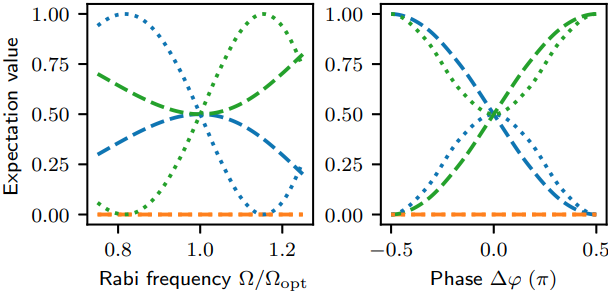

"FIG. 6. Expected outcome probabilities of $P(\ket{|g, g})$ (green), $P(\ket{|e, e})$  (blue), and $P(\ket{|e, g})  + P(\ket{|g, e})$ (orange) for a 3 $U_{\text{MS}}^0 (\pi/2)$ gate sequence (dotted) and for a $ U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pi/4} (\pi/2) $ sequence (dashed). The first gate sequence is first-order insensitive to phase miscalibrations as the local minimum of the outcome probabilities around zero leads to only small variations in the likelihood of possible outcomes, and its symmetry around zero does not allow one to discriminate the sign of the miscalibration. Similar arguments can be used to see that this sequence is first-order sensitive to Rabi frequency miscalibrations. For the second gate sequence, the relation is inverted, being sensitive to phase miscalibrations at the cost of first-order insensitivity to the Rabi frequency. The qualitative behavior of the sensitivity of the center line matches the sensitivity of the phase difference, while the behavior of the sideband detuning matches the Rabi frequency."

Since we're not varying phase right now, let's stick with the first sequence of gates:
$N_g = 3 \Longrightarrow \boxed{m = U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2)} = U_{\text{MS}}^0 (3\pi/2)$

**TODO**: Consider a weighted-combination of Rabi-sensitive and phase-sensitive gates

**TODO**: Consider 50-50 split of $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{00} + i\ket{11}\right)$ and $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{01} + i\ket{10}\right)$ (or something else since this assumes perfect preparation of the initial state?)

### 1.b.ii. Compute $P(m|\widetilde{\Theta}^{(i)})$ by sampling $\texttt{particles\_I\_1d}$ and numerically integrating at that point.

**TODO:** Introduce depolarizing noise to account for SPAM error.

In [102]:
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

m_given_I_1d_dist = zeros((N_p_I_1d, 4))

for i in 1:length(particles_I_1d)

    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    I_i = particles_I_1d[i]
    update_intensity(MS_CHAMBER_UNTUNED, I_i)

    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ_final = ptrace(dm(sol[end]),3)
    probs = ZZ_probs(ρ_final)
    probs = probs ./ sum(probs)
    m_given_I_1d_dist[i, :] = [p for p in probs]
    
end


100
200
300
400
500
600
700
800
900
1000

## 1.c. Calibrate

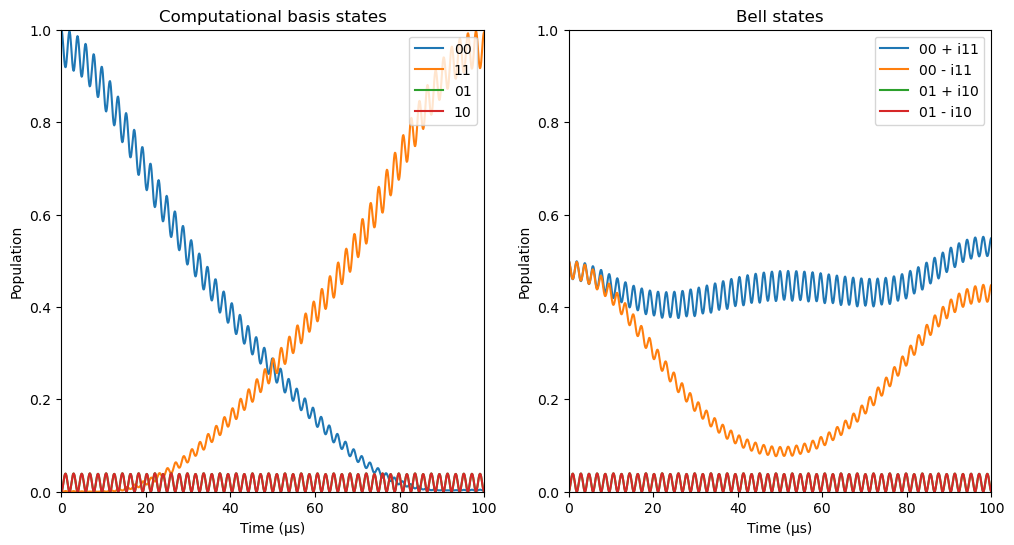


Initial infidelity = 0.2588109429615245

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [103]:
INFID_THRESH = 1.3e-2 # infidelity threshold
MAX_LOOPS = Int(1e3) # maximum number of loops
N_SHOTS = 100; # Number of shots per loop

# Initial theta
I_INITIAL = 2*INTENSITY_MS
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    I_INITIAL,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

# Initial belief about theta
I_bar = sum(particles_I_1d .* weights_I_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nInitial infidelity = ", infid)

plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)

In [104]:
loop = 0
I_infid_tracker = []
I_tracker = [I_INITIAL]
I_bar_tracker = [I_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        infid = 0
    end

    if loop%Int(1e1)==0
        print("\n", loop)
        flush(stdout)
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = ptrace(dm(sol[end]),3)
    fid = fidelity(ρ, ρ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(ρ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_p_I_1d
        w_i = weights_I_1d[i]
        theta_i = particles_I_1d[i]
        p_m_given_I_1d_dist = m_given_I_1d_dist[i, :]
        p_m = mean(p_m_given_I_1d_dist[m_t])
        weights_I_1d[i] = w_i * p_m
    end
    weights_I_1d = weights_I_1d ./ sum(weights_I_1d)
    I_bar = sum(particles_I_1d .* weights_I_1d)
    
    # Update parameters
    I_new = compute_I_new(MS_CHAMBER_UNTUNED, I_bar)
    I = I_new
    update_intensity(MS_CHAMBER_UNTUNED, I)

    append!(I_infid_tracker, infid)
    append!(I_tracker, I_new)
    append!(I_bar_tracker, I_bar)
    print("\nI = ", I, ", I_bar = ", I_bar, ", infid = ", infid)
    flush(stdout)


end


I = 172426.04525262016, I_bar = 112916.553593811, infid = 0.2588109429615245
I = 150577.58993827133, I_bar = 123685.7035461247, infid = 0.18205648446843892
I = 128147.95768220873, I_bar = 130236.2125502259, infid = 0.09752570614962741
I = 107743.49560928714, I_bar = 133436.82740917188, infid = 0.036477390290257095
I = 90221.74847861013, I_bar = 134522.24205965063, infid = 0.006231858007879287

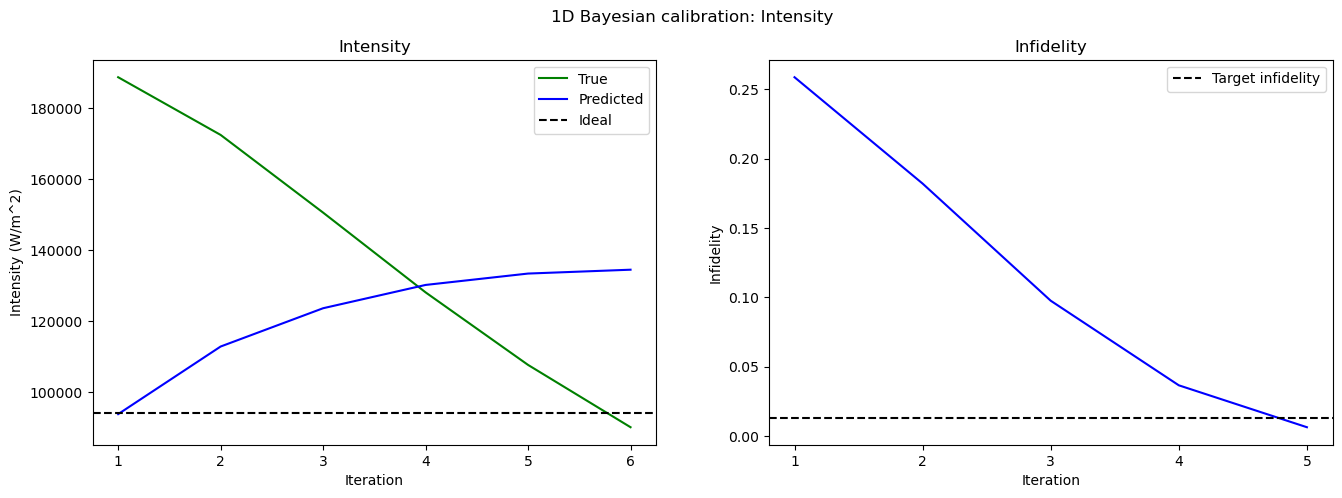

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(I_tracker), I_tracker, color="g", label = "True")
ax1.plot(1:length(I_bar_tracker), I_bar_tracker, color="b", label = "Predicted")
ax1.axhline(INTENSITY_MS, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=1:length(I_tracker))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Intensity (W/m^2)")
ax1.set_title("Intensity")
ax1.legend()


ax2.plot(1:length(I_infid_tracker), I_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=1:length(I_infid_tracker))
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Intensity")

plt.display(fig)

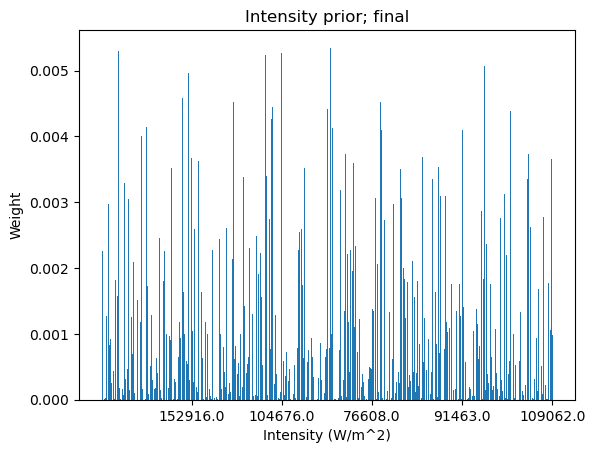

In [106]:
fig = plt.figure()
plt.bar(1:length(weights_I_1d), weights_I_1d)
plt.xlabel("Intensity (W/m^2)")
plt.xticks(ticks = [i for i in 1:length(weights_I_1d) if i%200==0], labels = [round(particles_I_1d[i]) for i in 1:length(weights_I_1d) if i%200==0])
plt.ylabel("Weight")
plt.title("Intensity prior; final")
plt.display(fig)

Not very illuminating...

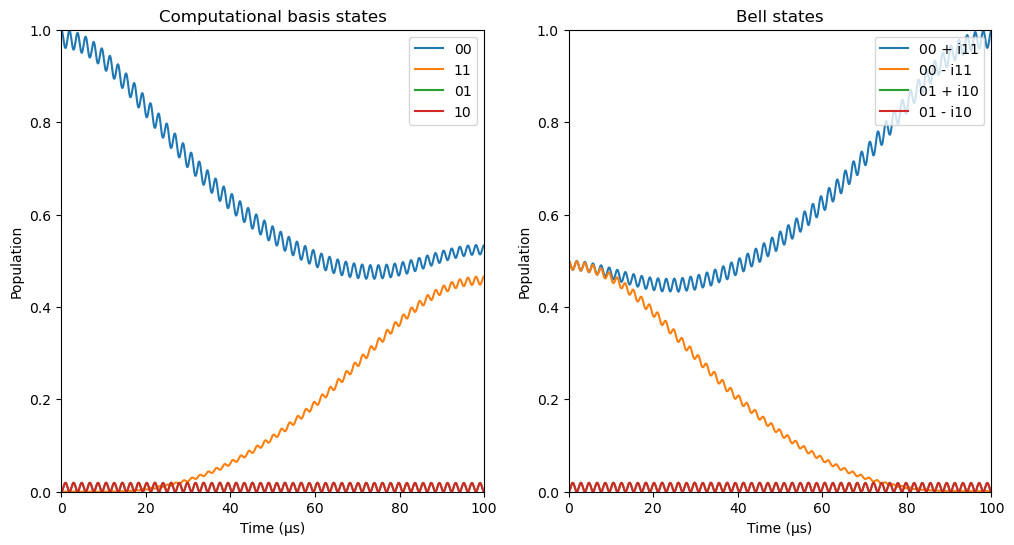


Final infidelity = 0.0009729254053295611

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [111]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nFinal infidelity = ", infid)

plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)

**IMPORTANT TODO:** Investigate runaway effect when $\texttt{I\_initial} < \texttt{INTENSITY\_MS}$ and $\texttt{INFID\_THRESH}$ is too small; recall Lukas: "the way you do the sampling is tricky, but important"

# 2. 1D Bayesian parameter calibration: Center-line frequency

$\Longrightarrow \boxed{P(\Theta) = \frac{1}{\sqrt{2\pi \sigma_{f_{\text{cl}}}}} \exp\left[-\frac{1}{2}  \frac{(i - \mu_{f_{\text{cl}}})^2}{\sigma_{f_{\text{cl}}}^2} \right]}  $

## 2.a. Compute the initial prior

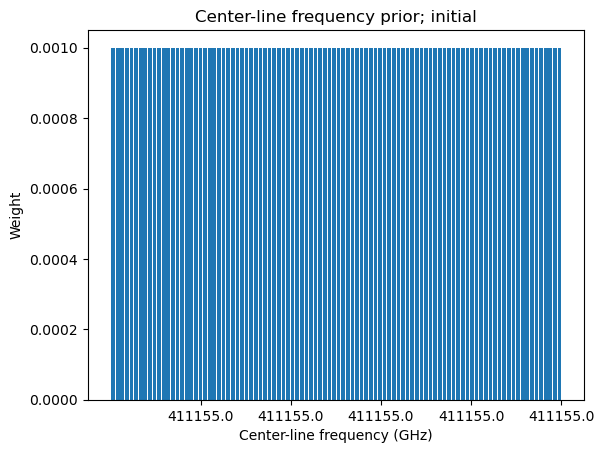

In [282]:
N_p_f_cl_1d = Int(1e3)
particles_f_cl_1d = []
weights_f_cl_1d = []

n_collected_f_cl_1d = 0
while n_collected_f_cl_1d < N_p_f_cl_1d
    f_cl_new = rand(Normal_f_cl)[1]
    λ_cl_new = C0/f_cl_new
    δλ_cl_new = abs(WAVELENGTH_CL_MS - λ_cl_new)
    if δλ_cl_new > δλ_MAX
        continue
    end

    append!(particles_f_cl_1d, f_cl_new)
    append!(weights_f_cl_1d, 1.0)
    n_collected_f_cl_1d += 1
end

weights_f_cl_1d = weights_f_cl_1d ./ sum(weights_f_cl_1d);

fig = plt.figure()
plt.bar(1:length(weights_f_cl_1d), weights_f_cl_1d)
plt.xlabel("Center-line frequency (GHz)")
plt.xticks(ticks = [i for i in 1:length(weights_f_cl_1d) if i%200==0], labels = [round(particles_f_cl_1d[i]*1e-9) for i in 1:length(weights_f_cl_1d) if i%200==0])
plt.ylabel("Weight")
plt.title("Center-line frequency prior; initial")
plt.display(fig)

## 2.b. Compute $P(m|\Theta)$

In [150]:
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

m_given_f_cl_1d_dist = zeros((N_p_f_cl_1d, 4))

for i in 1:length(particles_f_cl_1d)

    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    f_cl_i = particles_f_cl_1d[i]
    update_f_cl(MS_CHAMBER_UNTUNED, f_cl_i)

    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ_final = ptrace(dm(sol[end]),3)
    probs = ZZ_probs(ρ_final)
    probs = probs ./ sum(probs)
    m_given_f_cl_1d_dist[i, :] = [p for p in probs]
    
end


100
200
300
400
500
600
700
800
900
1000

In [179]:
m_given_f_cl_1d_dist

1000×4 Matrix{Float64}:
 0.500001  0.498668  0.000665557  0.000665557
 0.514289  0.430534  0.0275885    0.0275885
 0.488031  0.433414  0.0392772    0.0392772
 0.518071  0.421583  0.0301732    0.0301732
 0.502382  0.488045  0.00478659   0.00478659
 0.501786  0.469549  0.0143329    0.0143329
 0.662608  0.226674  0.0553593    0.0553593
 0.378932  0.299283  0.160893     0.160893
 0.502263  0.485609  0.00606402   0.00606402
 0.504612  0.458382  0.0185027    0.0185027
 ⋮                                
 0.480919  0.418336  0.0503724    0.0503724
 0.49994   0.49857   0.000744982  0.000744982
 0.499176  0.466288  0.0172683    0.0172683
 0.547617  0.366066  0.0431582    0.0431582
 0.517436  0.423037  0.0297634    0.0297634
 0.681011  0.209354  0.0548175    0.0548175
 0.499395  0.496998  0.00180382   0.00180382
 0.499333  0.466956  0.0168553    0.0168553
 0.502406  0.489059  0.00426718   0.00426718

## 2.c. Calibrate

**NOTE** the use of $\texttt{FINITE\_RWA\_CUTOFF}$

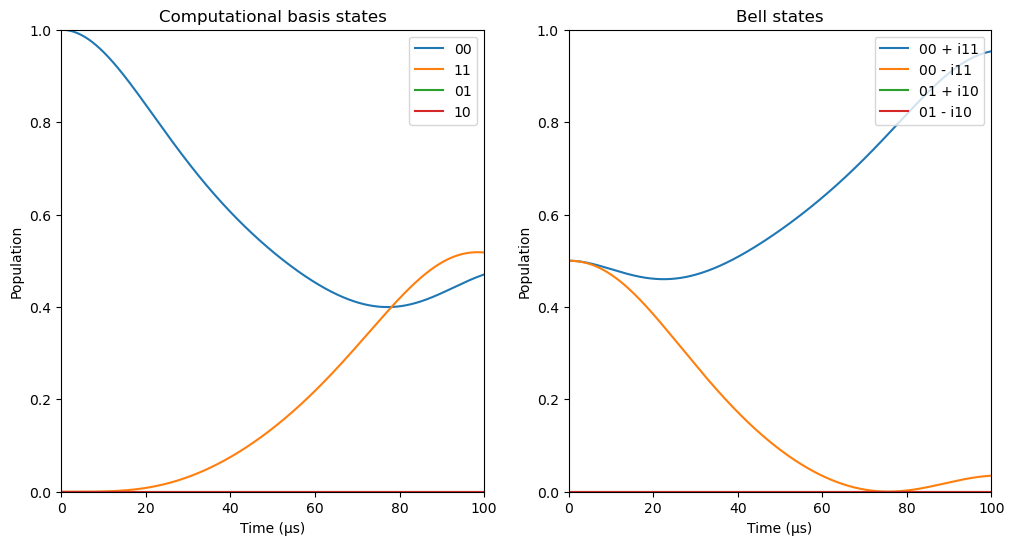


Initial infidelity = 0.02342241289573166

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [283]:
FINITE_RWA_CUTOFF = 1e5

# Initial theta
λ_CL_INITIAL = WAVELENGTH_CL_MS + δλ_MAX*1e-3
F_CL_INITIAL = C0/λ_CL_INITIAL
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    λ_CL_INITIAL,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

# Initial belief about theta
f_cl_bar = sum(particles_f_cl_1d .* weights_f_cl_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=FINITE_RWA_CUTOFF)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nInitial infidelity = ", infid)

plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)

In [284]:
loop = 0
f_cl_infid_tracker = []
f_cl_tracker = [F_CL_INITIAL]
f_cl_bar_tracker = [f_cl_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    print("\n\nf_cl = ", C0/MS_CHAMBER_UNTUNED.lasers[1].λ, ", δλ_cl = ", abs(MS_CHAMBER_UNTUNED.lasers[1].λ - WAVELENGTH_CL_MS))

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=FINITE_RWA_CUTOFF)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = ptrace(dm(sol[end]),3)
    fid = fidelity(ρ, ρ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(ρ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_p_f_cl_1d
        w_i = weights_f_cl_1d[i]
        theta_i = particles_f_cl_1d[i]
        p_m_given_f_cl_1d_dist = m_given_f_cl_1d_dist[i, :]
        p_m = mean(p_m_given_f_cl_1d_dist[m_t])
        weights_f_cl_1d[i] = w_i * p_m
    end
    weights_f_cl_1d = weights_f_cl_1d ./ sum(weights_f_cl_1d)
    f_cl_bar = sum(particles_f_cl_1d .* weights_f_cl_1d)
    
    # Update parameters
    f_cl_new = compute_f_cl_new(MS_CHAMBER_UNTUNED, f_cl_bar)
    λ_cl_new = C0/f_cl_new
    δλ_cl_new = abs(WAVELENGTH_CL_MS - λ_cl_new)
    if δλ_cl_new > δλ_MAX
        print("Runaway into non-integrable region")
        flush(stdout)
        break
    end
    update_f_cl(MS_CHAMBER_UNTUNED, f_cl_new)

    append!(f_cl_infid_tracker, infid)
    append!(f_cl_tracker, f_cl_new)
    append!(f_cl_bar_tracker, f_cl_bar)
    print(", f_cl_bar = ", f_cl_bar, "\nf_cl_new = ", f_cl_new,  ", δλ_cl_new = ", abs(WAVELENGTH_CL_MS - C0/f_cl_new),  ", infid = ", infid)
    flush(stdout)


end



f_cl = 4.11155035205163e14, δλ_cl = 1.0000282733521083e-18, f_cl_bar = 4.1115503520575094e14
f_cl_new = 4.1115503520513894e14, δλ_cl_new = 1.0426975580700437e-18, infid = 0.02342241289573166

f_cl = 4.1115503520513894e14, δλ_cl = 1.0426975580700437e-18, f_cl_bar = 4.111550352057574e14
f_cl_new = 4.1115503520510844e14, δλ_cl_new = 1.0968017875759122e-18, infid = 0.025727115199730477

f_cl = 4.1115503520510844e14, δλ_cl = 1.0968017875759122e-18, f_cl_bar = 4.1115503520576425e14
f_cl_new = 4.1115503520507106e14, δλ_cl_new = 1.1630821156985612e-18, infid = 0.02881765604972375

f_cl = 4.1115503520507106e14, δλ_cl = 1.1630821156985612e-18, f_cl_bar = 4.111550352057707e14
f_cl_new = 4.1115503520502725e14, δλ_cl_new = 1.2407973886091432e-18, infid = 0.03286452465977363

f_cl = 4.1115503520502725e14, δλ_cl = 1.2407973886091432e-18, f_cl_bar = 4.1115503520577575e14
f_cl_new = 4.111550352049784e14, δλ_cl_new = 1.3274065074658954e-18, infid = 0.0379750388020762

f_cl = 4.111550352049784e14, δλ_c

## 2.d. Analyze results

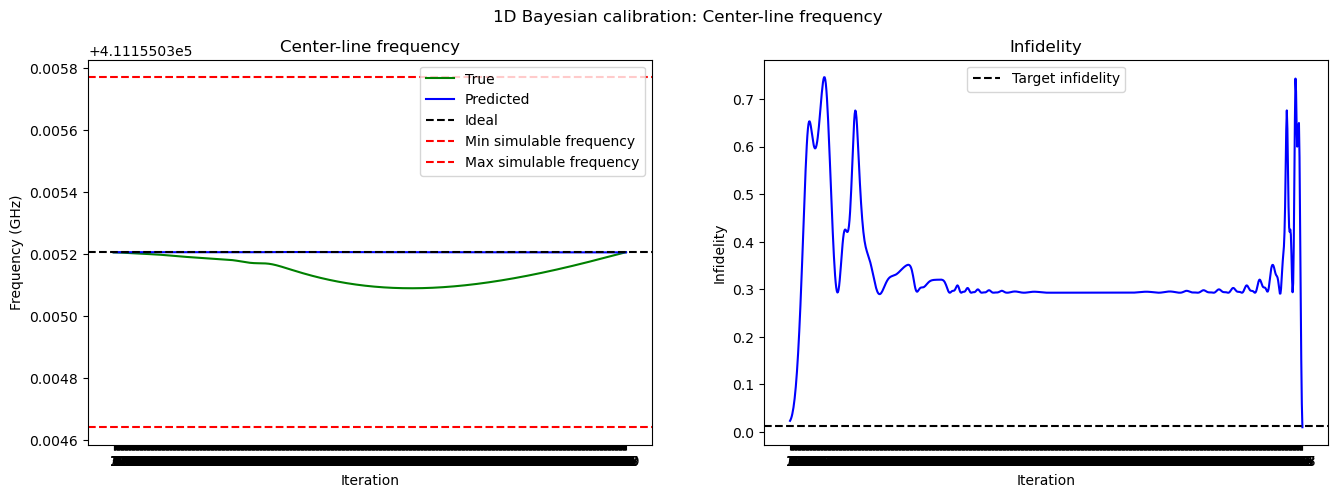

In [285]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(f_cl_tracker), f_cl_tracker*1e-9, color="g", label = "True")
ax1.plot(1:length(f_cl_bar_tracker), f_cl_bar_tracker*1e-9, color="b", label = "Predicted")
ax1.axhline(FREQUENCY_CL_MS*1e-9, color="k", linestyle="--", label = "Ideal")
ax1.axhline(C0*1e-9/(WAVELENGTH_CL_MS+δλ_MAX), color="r", linestyle="--", label = "Min simulable frequency")
ax1.axhline(C0*1e-9/(WAVELENGTH_CL_MS-δλ_MAX), color="r", linestyle="--", label = "Max simulable frequency")
ax1.set_xticks(ticks=1:length(f_cl_tracker))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency (GHz)")
ax1.set_title("Center-line frequency")
ax1.legend()


ax2.plot(1:length(f_cl_infid_tracker), f_cl_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=1:length(f_cl_infid_tracker))
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Center-line frequency")

plt.display(fig)

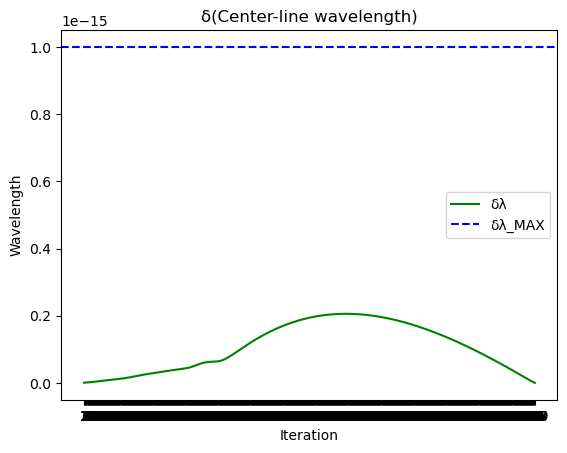

In [286]:
λ_cl_tracker = C0 ./ f_cl_tracker
δλ_cl_tracker = broadcast(abs, λ_cl_tracker .- WAVELENGTH_CL_MS)

fig = plt.figure()

plt.plot(1:length(δλ_cl_tracker), δλ_cl_tracker, color="g", label = "δλ")
plt.axhline(δλ_MAX, color="b", linestyle="--", label = "δλ_MAX")
plt.xticks(ticks=1:length(δλ_cl_tracker))
plt.xlabel("Iteration")
plt.ylabel("Wavelength")
plt.title("δ(Center-line wavelength)")
plt.legend()
plt.display(fig)

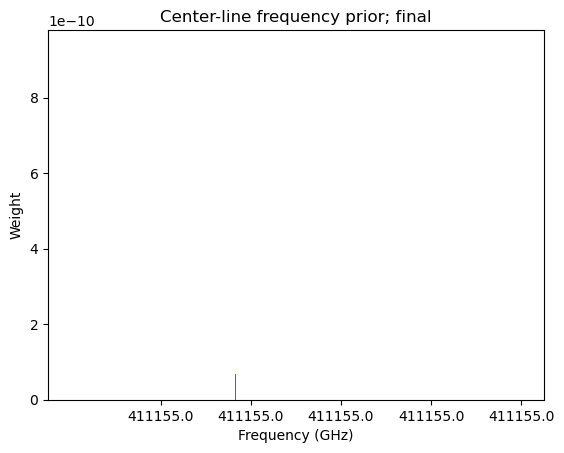

In [287]:
fig = plt.figure()
plt.bar(1:length(weights_f_cl_1d), weights_f_cl_1d*1e-9)
plt.xlabel("Frequency (GHz)")
plt.xticks(ticks = [i for i in 1:length(weights_f_cl_1d) if i%200==0], labels = [round(particles_f_cl_1d[i]*1e-9) for i in 1:length(weights_f_cl_1d) if i%200==0])
plt.ylabel("Weight")
plt.title("Center-line frequency prior; final")
plt.display(fig)

Again, not very illuminating

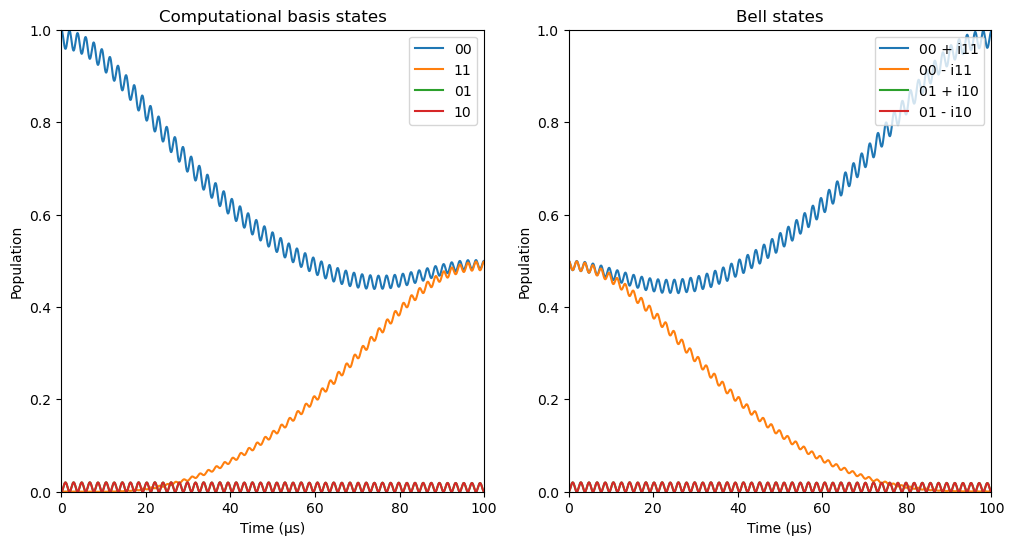


Final infidelity = 0.001700225825851387

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [288]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nFinal infidelity = ", infid)

plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)

# 3. 1D Bayesian parameter calibration: trap frequency

## 3.a. Compute the initial prior

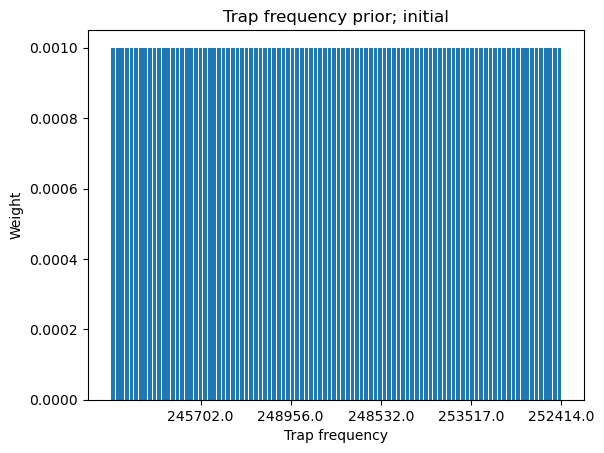

In [17]:
N_p_ν_1d = Int(1e3)
particles_ν_1d = []
weights_ν_1d = []

n_collected_ν_1d = 0
while n_collected_ν_1d < N_p_ν_1d
    ν_new = rand(Normal_ν)[1]
    append!(particles_ν_1d, ν_new)
    append!(weights_ν_1d, 1.0)
    n_collected_ν_1d += 1
end

weights_ν_1d = weights_ν_1d ./ sum(weights_ν_1d);

fig = plt.figure()
plt.bar(1:length(weights_ν_1d), weights_ν_1d)
plt.xlabel("Trap frequency")
plt.xticks(ticks = [i for i in 1:length(weights_ν_1d) if i%200==0], labels = [round(particles_ν_1d[i]) for i in 1:length(weights_ν_1d) if i%200==0])
plt.ylabel("Weight")
plt.title("Trap frequency prior; initial")
plt.display(fig)

## 3.b. Compute $P(m|\Theta)$

In [18]:
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

m_given_ν_1d_dist = zeros((N_p_ν_1d, 4))

for i in 1:length(particles_ν_1d)

    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    try
        ν_i = particles_ν_1d[i]
        MS_CHAMBER_UNTUNED = update_ν(MS_CHAMBER_UNTUNED, ν_i)
        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
        ρ_final = ptrace(dm(sol[end]),3)
        probs = ZZ_probs(ρ_final)
        probs = probs ./ sum(probs)
        m_given_ν_1d_dist[i, :] = [p for p in probs]
    catch
        m_given_ν_1d_dist[i, :] = [NaN for p in 1:4]
        particles_ν_1d[i] = NaN
        weights_ν_1d[i] = NaN
    end
end


100
200
300
400
500
600
700
800
900
1000

In [22]:
sum(isnan.(particles_ν_1d))

0

In [28]:
m_given_ν_1d_dist

1000×4 Matrix{Float64}:
 0.489194  0.477612  0.016597     0.016597
 0.484124  0.490351  0.0127626    0.0127626
 0.477071  0.485998  0.0184654    0.0184654
 0.474041  0.485028  0.0204655    0.0204655
 0.49259   0.495962  0.00572373   0.00572373
 0.477324  0.486136  0.0182701    0.0182701
 0.49989   0.478233  0.0109383    0.0109383
 0.500112  0.499172  0.000358271  0.000358271
 0.49168   0.473371  0.0174745    0.0174745
 0.48749   0.473312  0.0195993    0.0195993
 ⋮                                
 0.476483  0.493556  0.0149801    0.0149801
 0.473401  0.486946  0.0198266    0.0198266
 0.500012  0.496176  0.00190575   0.00190575
 0.498424  0.499058  0.00125903   0.00125903
 0.495119  0.487404  0.00873844   0.00873844
 0.492782  0.483663  0.0117776    0.0117776
 0.50054   0.498049  0.000705569  0.000705569
 0.478475  0.486766  0.0173795    0.0173795
 0.487586  0.472676  0.0198693    0.0198693

## 3.c. Calibrate

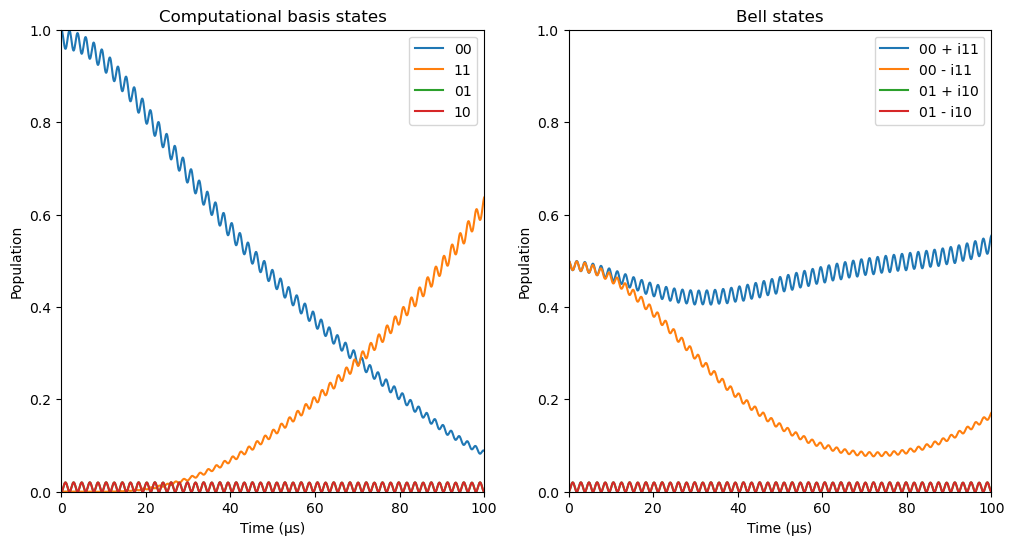


Initial infidelity = 0.23019142760347877

In [29]:
# Initial theta
ν_INITIAL = 1.01*TRAP_FREQUENCY
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    ν_INITIAL,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
# Remember, the detuning is based on the target trap-frequency, not the true trap-frequency
MS_CHAMBER_UNTUNED.lasers[1].Δ = TRAP_FREQUENCY + DETUNING - AC_CORRECTION
MS_CHAMBER_UNTUNED.lasers[2].Δ = -(TRAP_FREQUENCY + DETUNING - AC_CORRECTION)

# Initial belief about theta
ν_bar = sum(particles_ν_1d .* weights_ν_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nInitial infidelity = ", infid)

plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)

In [30]:
loop = 0
ν_infid_tracker = []
ν_tracker = [ν_INITIAL]
ν_bar_tracker = [ν_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = ptrace(dm(sol[end]),3)
    fid = fidelity(ρ, ρ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(ρ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_p_ν_1d
        w_i = weights_ν_1d[i]
        theta_i = particles_ν_1d[i]
        p_m_given_ν_1d_dist = m_given_ν_1d_dist[i, :]
        p_m = mean(p_m_given_ν_1d_dist[m_t])
        weights_ν_1d[i] = w_i * p_m
    end
    weights_ν_1d = weights_ν_1d ./ sum(weights_ν_1d)
    ν_bar = sum(particles_ν_1d .* weights_ν_1d)
    
    # Update parameters
    ν_new = compute_ν_new(MS_CHAMBER_UNTUNED, ν_bar)
    MS_CHAMBER_UNTUNED = update_ν(MS_CHAMBER_UNTUNED, ν_new)

    append!(ν_infid_tracker, infid)
    append!(ν_tracker, ν_new)
    append!(ν_bar_tracker, ν_bar)
    print("\nν_bar = ", ν_bar, ", ν_new = ", ν_new, ", infid = ", infid)
    flush(stdout)


end


ν_bar = 249923.938063264, ν_new = 252576.061936736, infid = 0.23019142760347877
ν_bar = 249928.32257874848, ν_new = 252647.7393579875, infid = 0.02009470285101811
ν_bar = 249934.47069734862, ν_new = 252713.2686606389, infid = 0.019947312613166845
ν_bar = 249933.85122099993, ν_new = 252779.41743963896, infid = 0.019744615208392546
ν_bar = 249937.13768421212, ν_new = 252842.27975542683, infid = 0.019475874984991814
ν_bar = 249938.59615791045, ν_new = 252903.68359751638, infid = 0.019162207899088735
ν_bar = 249940.44362384436, ν_new = 252963.23997367203, infid = 0.018803016421564456
ν_bar = 249944.97920791415, ν_new = 253018.26076575788, infid = 0.01840676266407293
ν_bar = 249948.7212186999, ν_new = 253069.53954705797, infid = 0.018000738731832056
ν_bar = 249948.66810912656, ν_new = 253120.8714379314, infid = 0.01758941032685124
ν_bar = 249952.33697773344, ν_new = 253168.53446019796, infid = 0.01714778777481374
ν_bar = 249952.91424691162, ν_new = 253215.62021328634, infid = 0.01671231927

## 3.d. Analyze results

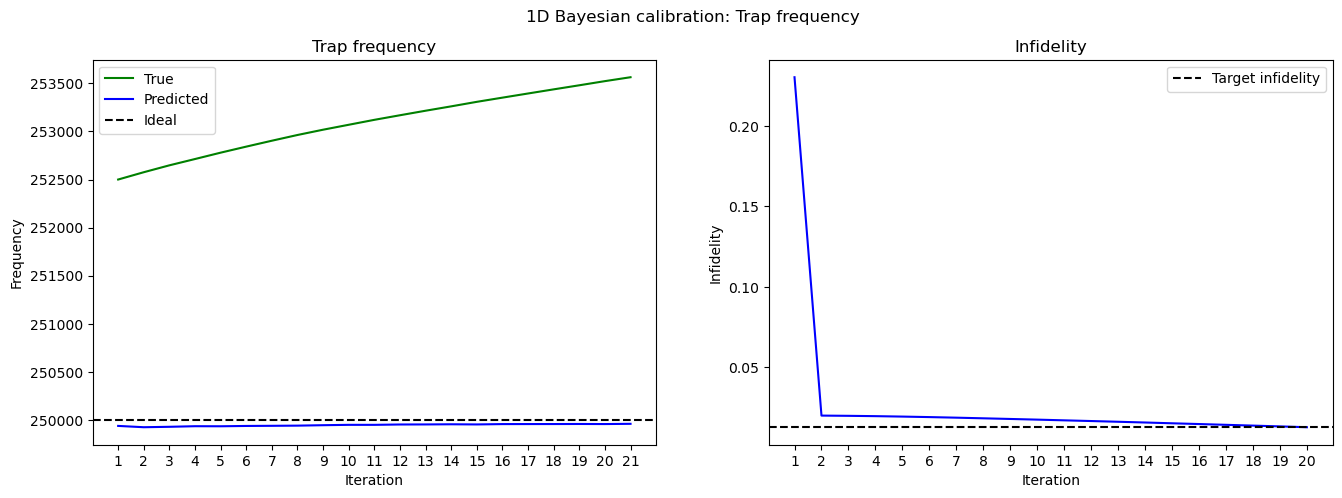

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(ν_tracker), ν_tracker, color="g", label = "True")
ax1.plot(1:length(ν_bar_tracker), ν_bar_tracker, color="b", label = "Predicted")
ax1.axhline(TRAP_FREQUENCY, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=1:length(ν_tracker))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency")
ax1.set_title("Trap frequency")
ax1.legend()


ax2.plot(1:length(ν_infid_tracker), ν_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=1:length(ν_infid_tracker))
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Trap frequency")

plt.display(fig)

In [36]:
ν_tracker[end]

253564.05658874105

In [37]:
TRAP_FREQUENCY

250000.0

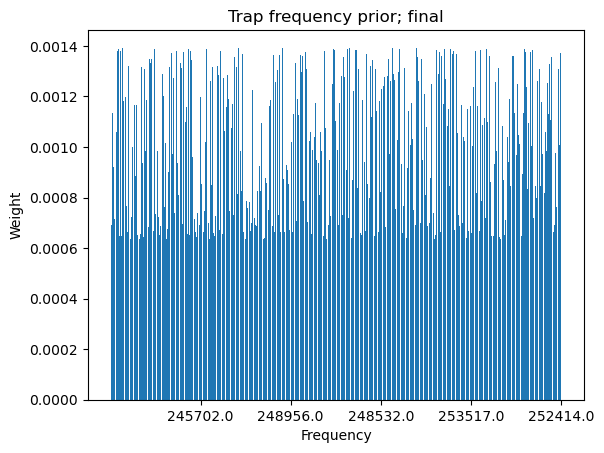

In [32]:
fig = plt.figure()
plt.bar(1:length(weights_ν_1d), weights_ν_1d)
plt.xlabel("Frequency")
plt.xticks(ticks = [i for i in 1:length(weights_ν_1d) if i%200==0], labels = [round(particles_ν_1d[i]) for i in 1:length(weights_ν_1d) if i%200==0])
plt.ylabel("Weight")
plt.title("Trap frequency prior; final")
plt.display(fig)

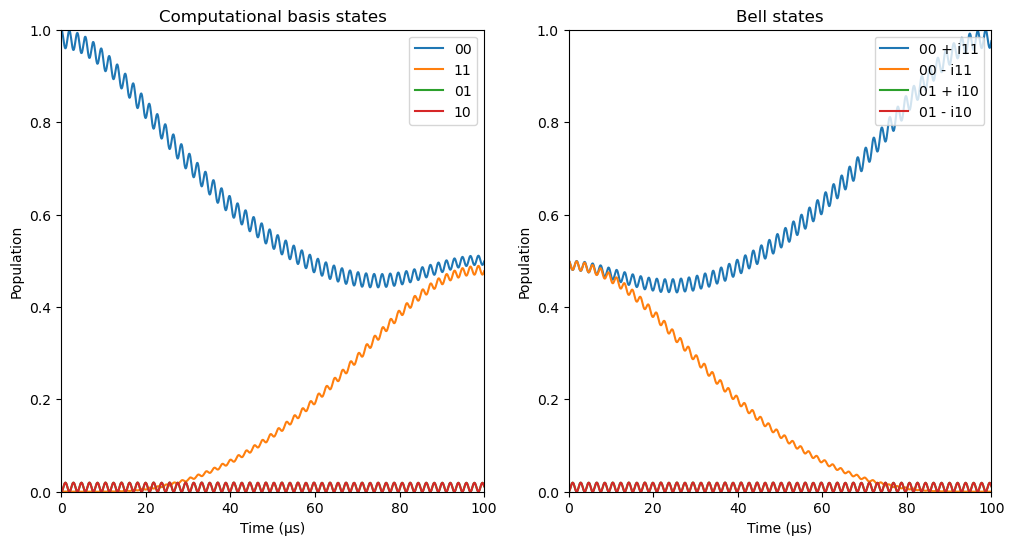


Final infidelity = 0.012385033102302656

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [33]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nFinal infidelity = ", infid)

plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)

# 4. 1D Bayesian parameter calibration: Phase of lasers

## 4.a. Compute initial prior

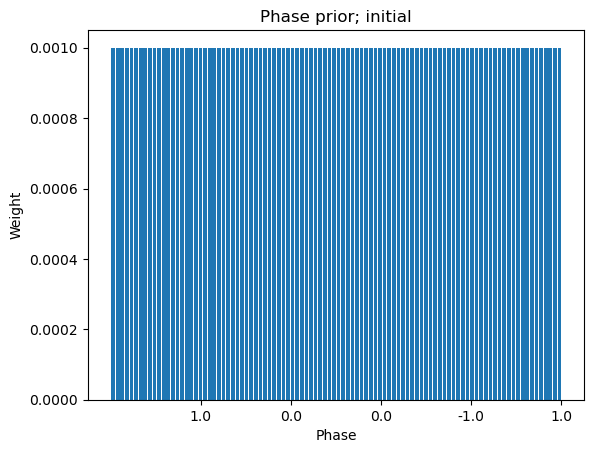

In [72]:
N_p_ϕ_1d = Int(1e3)
particles_ϕ_1d = []
weights_ϕ_1d = []

n_collected_ϕ_1d = 0
while n_collected_ϕ_1d < N_p_ϕ_1d
    ϕ_new = rand(Normal_ϕ)[1]
    append!(particles_ϕ_1d, ϕ_new)
    append!(weights_ϕ_1d, 1.0)
    n_collected_ϕ_1d += 1
end

weights_ϕ_1d = weights_ϕ_1d ./ sum(weights_ϕ_1d);

fig = plt.figure()
plt.bar(1:length(weights_ϕ_1d), weights_ϕ_1d)
plt.xlabel("Phase")
plt.xticks(ticks = [i for i in 1:length(weights_ϕ_1d) if i%200==0], labels = [round(particles_ϕ_1d[i]) for i in 1:length(weights_ϕ_1d) if i%200==0])
plt.ylabel("Weight")
plt.title("Phase prior; initial")
plt.display(fig)

## 4.b. Compute $P(m|\Theta)$

In [66]:
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)

m_given_ϕ_1d_dist = zeros((N_p_ϕ_1d, 4))

for i in 1:length(particles_ϕ_1d)

    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end


    ϕ_i = particles_ϕ_1d[i]
    phase!(MS_CHAMBER_UNTUNED.lasers[2], ϕ_i)
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ_final = ptrace(dm(sol[end]),3)
    probs = ZZ_probs(ρ_final)
    probs = probs ./ sum(probs)
    m_given_ϕ_1d_dist[i, :] = [p for p in probs]

end


100
200
300
400
500
600
700
800
900
1000

## 4.c. Calibrate

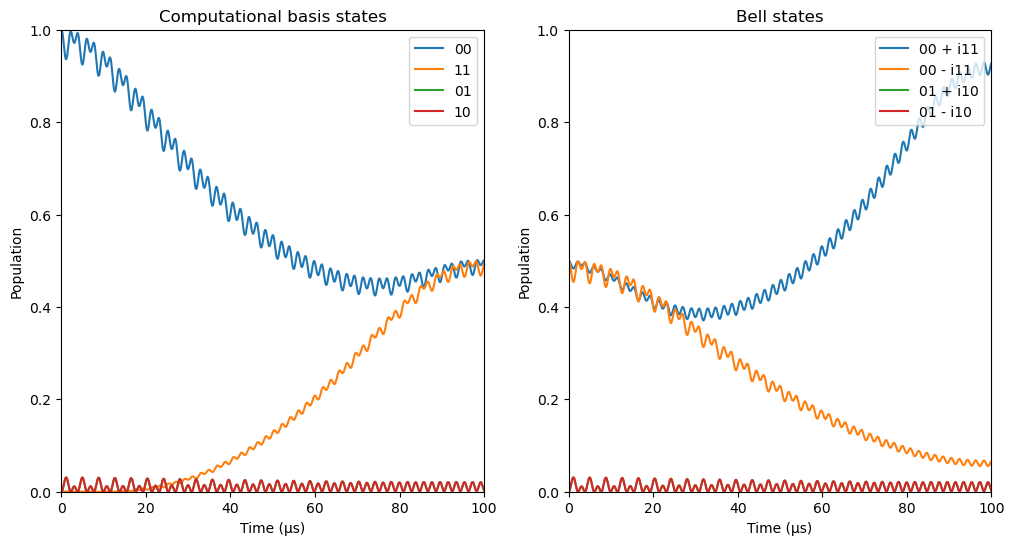


Initial infidelity = 0.03694916253635472

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [73]:
# Initial theta
ϕ_INITIAL = σ_ϕ
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)
phase!(MS_CHAMBER_UNTUNED.lasers[2], ϕ_INITIAL)

# Initial belief about theta
ϕ_bar = sum(particles_ϕ_1d .* weights_ϕ_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nInitial infidelity = ", infid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
plt.display(fig)
plt.close(fig)

In [74]:
loop = 0
ϕ_infid_tracker = []
ϕ_tracker = [ϕ_INITIAL]
ϕ_bar_tracker = [ϕ_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = ptrace(dm(sol[end]),3)
    fid = fidelity(ρ, ρ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(ρ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_p_ϕ_1d
        w_i = weights_ϕ_1d[i]
        theta_i = particles_ϕ_1d[i]
        p_m_given_ϕ_1d_dist = m_given_ϕ_1d_dist[i, :]
        p_m = mean(p_m_given_ϕ_1d_dist[m_t])
        weights_ϕ_1d[i] = w_i * p_m
    end
    weights_ϕ_1d = weights_ϕ_1d ./ sum(weights_ϕ_1d)
    ϕ_bar = sum(particles_ϕ_1d .* weights_ϕ_1d)
    
    # Update parameters
    ϕ_new = compute_ϕ_new(MS_CHAMBER_UNTUNED, ϕ_bar)%2π
    update_ϕ(MS_CHAMBER_UNTUNED, ϕ_new)

    append!(ϕ_infid_tracker, infid)
    append!(ϕ_tracker, ϕ_new)
    append!(ϕ_bar_tracker, ϕ_bar)
    print("\nϕ_bar = ", ϕ_bar, ", ϕ_new = ", ϕ_new, ", infid = ", infid)
    flush(stdout)

end


ϕ_bar = 0.014803168665290084, ϕ_new = 0.48785165590907686, infid = 0.03694916253635472
ϕ_bar = 0.014912159003728722, ϕ_new = 0.47293949690534814, infid = 0.03496100273527869
ϕ_bar = 0.014995843863914622, ϕ_new = 0.45794365304143353, infid = 0.03301185514361593
ϕ_bar = 0.01510288327633261, ϕ_new = 0.4428407697651009, infid = 0.03110632245480438
ϕ_bar = 0.015214874108498757, ϕ_new = 0.42762589565660214, infid = 0.029242753313222014
ϕ_bar = 0.015298870646786285, ϕ_new = 0.41232702500981583, infid = 0.02742199095890696
ϕ_bar = 0.015381222108624451, ϕ_new = 0.39694580290119136, infid = 0.025648741975416334
ϕ_bar = 0.015480537734177074, ϕ_new = 0.3814652651670143, infid = 0.023924403073458222
ϕ_bar = 0.015570346960668871, ϕ_new = 0.3658949182063454, infid = 0.022248359592719424
ϕ_bar = 0.015647369009413478, ϕ_new = 0.3502475491969319, infid = 0.020623020205009057
ϕ_bar = 0.015710744299468435, ϕ_new = 0.33453680489746346, infid = 0.019050931866072762
ϕ_bar = 0.01577987786237104, ϕ_new = 0.31

## 4.d. Analyze results

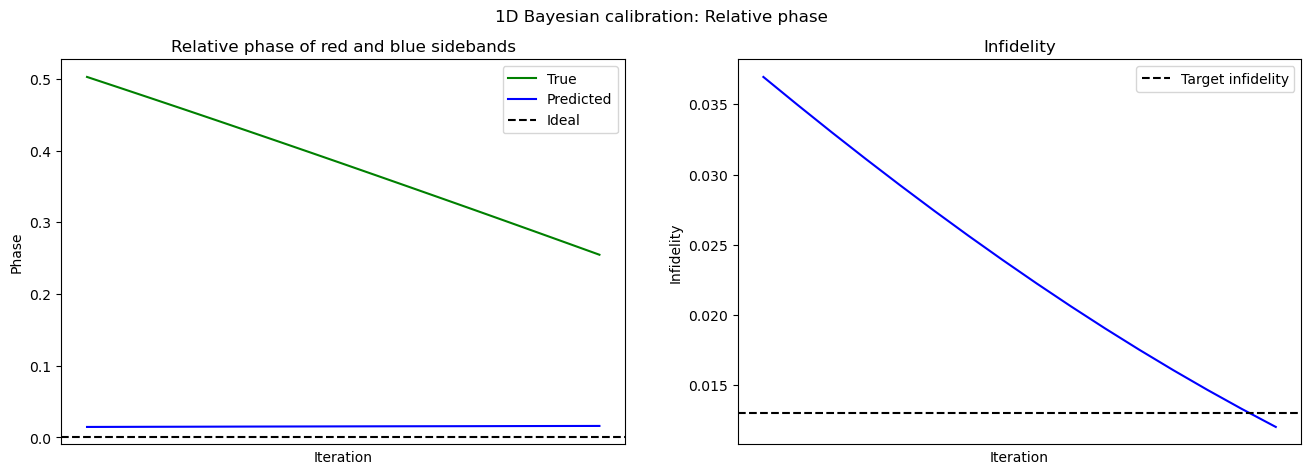

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(ϕ_tracker), ϕ_tracker, color="g", label = "True")
ax1.plot(1:length(ϕ_bar_tracker), ϕ_bar_tracker, color="b", label = "Predicted")
ax1.axhline(PHASE, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=[i for i in 1:length(ϕ_tracker) if i%100==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Phase")
ax1.set_title("Relative phase of red and blue sidebands")
ax1.legend()


ax2.plot(1:length(ϕ_infid_tracker), ϕ_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(ϕ_infid_tracker) if i%100==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Relative phase")

plt.display(fig)
plt.close(fig)

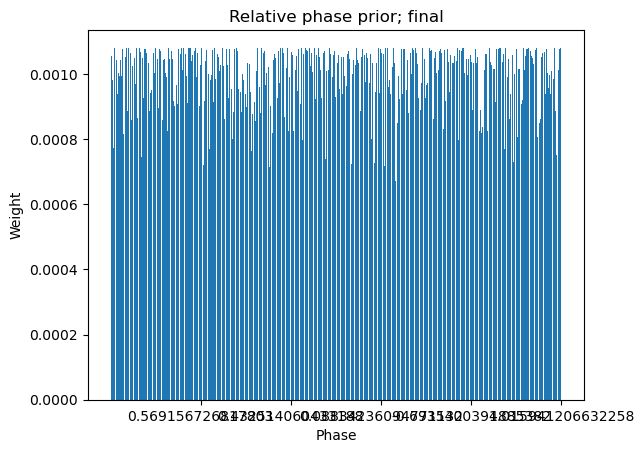

In [76]:
fig = plt.figure()
plt.bar(1:length(weights_ϕ_1d), weights_ϕ_1d)
plt.xlabel("Phase")
plt.xticks(ticks = [i for i in 1:length(weights_ϕ_1d) if i%200==0], labels = [particles_ϕ_1d[i] for i in 1:length(weights_ϕ_1d) if i%200==0])
plt.ylabel("Weight")
plt.title("Relative phase prior; final")
plt.display(fig)
plt.close(fig)

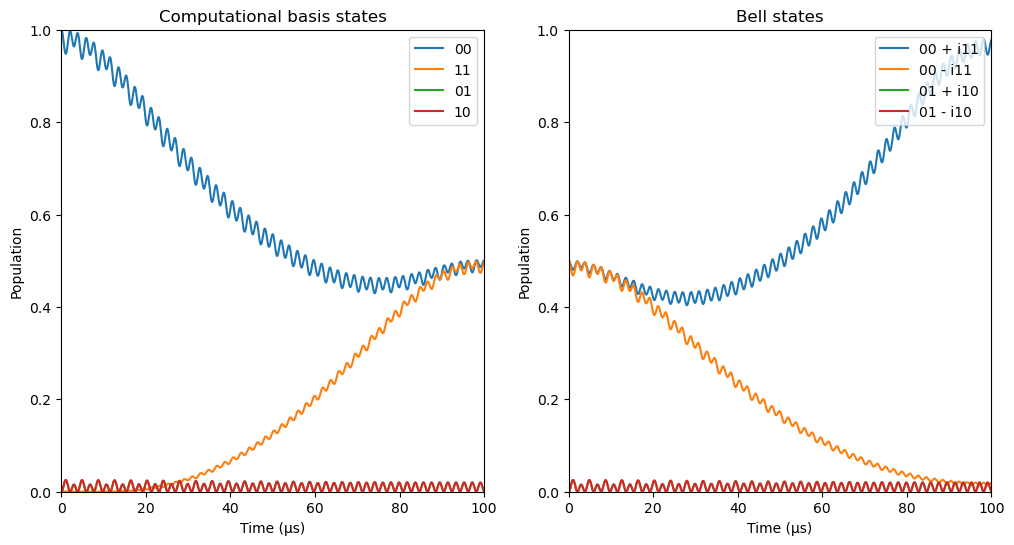


Final infidelity = 0.010805641525070797

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [77]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nFinal infidelity = ", infid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
plt.display(fig)
plt.close(fig)